
# Modelagem de um classificador binário de convenios  

Todos os convênios que não estavam na situação 'em execução' foram classificados entre insucesso e não-insucesso.  
Foram classifcados como insucesso os convênios cuja situação era 'Prestação de Contas Rejeitada', 'Inadimplente', 'Convênio Rescindido' os demais foram classificados com não-insucesso.

## 1. Importando as bibliotecas

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle

from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, mean_squared_error

import nltk
_ = nltk.download('rslp', quiet=True)


## 2. Definição da classe TextTransformer  
> Esta classe realiza a o agrupamento (clustering) de textos com o algorítimo K-Means.  
> A finalidade aqui é representar os textos da coluna 'OBJETO_PROPOSTA' em classes designadas por números inteiros.

In [43]:
#TEXT TRANSFORMER
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
import re

        
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=5, stop_words=[], accented=[]):
        self.__n_clusters__ = n_clusters
        self.__stop_words__ = stop_words
        self.__accented__ = accented
        self.labels_ = None
        self.__vectorizer__ = TfidfVectorizer(use_idf=True)
        self.__clusterer__ = KMeans(n_clusters=self.__n_clusters__, random_state=0)
    
    def fit(self, X):
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.fit_transform(X)
        self.__clusterer__ = self.__clusterer__.fit(X)
        self.labels_ = self.__clusterer__.labels_
        return self

    def fit_transform(self, X):
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.fit_transform(X)
        X = self.__clusterer__.fit_transform(X)
        self.labels_ = self.__clusterer__.labels_
        return X
    
    def fit_predict(self, X):
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.fit_transform(X)
        y = self.__clusterer__.fit_predict(X)
        self.labels_ = self.__clusterer__.labels_
        return y
    
    def transform(self, X):        
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.transform(X)
        X = self.__clusterer__.transform(X)
        return X
                       
    def predict(self, X):
        return_unique = False
        if type(X)==str:
            X = [X]
            return_unique = True
        
        X = self.__preprocessing__(X)
        X = self.__vectorizer__.transform(X)
        y = self.__clusterer__.predict(X)
        y = y[0] if return_unique else y
        return y
    
    def __preprocessing__(self, X):
        X = [' '.join(self.__text_preprocessing__(t)) for t in X]
        return X
    
    def __stemming__(self, tokens):  
        stemmer = nltk.stem.RSLPStemmer()
        return [stemmer.stem(token) for token in tokens]

    def __remove_accents__(self, text):
        for idx in self.__accented__.index:
            text = text.replace(self.__accented__['char_acc'][idx], self.__accented__['char_norm'][idx]) 
        return text

    def __text_preprocessing__(self, text):
        text = text.lower()
        text = self.__remove_accents__(text)
        tokens = re.findall('[a-z]+', text)
        tokens = filter(lambda w: w is not None, map(lambda w: None if w in self.__stop_words__ or len(w)==1 else w , tokens))
        tokens = self.__stemming__(tokens)
        return tokens

## 3. Definição da função make_transformers  
> Esta função prepara um conjunto transformadores (transformers) para converter e normalizar os dados.   
> 1. Para os dados categóricos foi utilizado o codificador (encoder) 'OneHotEncoder'.  
> 2. Os dados contínuos foram normalizados com o 'PowerTransformer'.  
>
> A função make_transformers recebe um dataframe com os dados brutos e retorna um dicionário contendo todos os transformadores treinados.  

In [23]:
#Columns Tranformations
def make_transformers(X, stop_words=[], accented=[]):
    data = X.copy()
    objeto_proposta_clusterer = TextTransformer(n_clusters=50, stop_words=stop_words, accented=accented).fit(data['OBJETO_PROPOSTA'])
    data['OBJETO_PROPOSTA'] = objeto_proposta_clusterer.predict(data['OBJETO_PROPOSTA'])
    data['OBJETO_PROPOSTA'] = data['OBJETO_PROPOSTA'].astype('int64')
    
    data_categorical_parlamentar = data.pop('PRINCIPAL_PARLAMENTAR').to_frame()
    data_categorical_fornecedor = data.pop('PRINCIPAL_FORNECEDOR').to_frame()
  
    data_categorical_object = data.select_dtypes(include=['object'])
    data_categorical_int = data.select_dtypes(include=['int64'])
    data_value = data.select_dtypes(include='float64')
    
    transformers = {}
    transformers['OBJETO_PROPOSTA_CLUSTERER'] = objeto_proposta_clusterer
    transformers['VALUE'] = PowerTransformer().fit(data_value)
    transformers['CATEGORICAL_OBJECT'] = OneHotEncoder(handle_unknown='ignore').fit(data_categorical_object)
    transformers['CATEGORICAL_INT'] = OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=500).fit(data_categorical_int)
    transformers['CATEGORICAL_PARLAMENTAR'] = OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=500).fit(data_categorical_parlamentar)
    transformers['CATEGORICAL_FORNECEDOR'] = OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=500).fit(data_categorical_fornecedor)
    
    return transformers

## 4. Definição da função data_preparation  
> Esta função utiliza os transformadores (transformers) para converter e normalizar os dados.  
> A finalidade aqui é adequar os dados para serem utilizados nos algorítimos.  

In [24]:
#Data Preparation
def data_preparation(transformers, X):
    data = X.copy()
    data['OBJETO_PROPOSTA'] = transformers['OBJETO_PROPOSTA_CLUSTERER'].predict(data['OBJETO_PROPOSTA'])
    data['OBJETO_PROPOSTA'] = data['OBJETO_PROPOSTA'].astype('int64')
    
    data_categorical_parlamentar = data.pop('PRINCIPAL_PARLAMENTAR').to_frame()
    data_categorical_fornecedor = data.pop('PRINCIPAL_FORNECEDOR').to_frame()
        
    data_categorical_object = data.select_dtypes(include=['object'])
    data_categorical_int = data.select_dtypes(include=['int64'])
    data_value = data.select_dtypes(include='float64')
    
    value_codes = transformers['VALUE'].transform(data_value)
    value_feature_names = transformers['VALUE'].feature_names_in_
    data_value = pd.DataFrame(value_codes, columns=value_feature_names).astype('float64')
    
    categorical_object_codes = transformers['CATEGORICAL_OBJECT'].transform(data_categorical_object).toarray()
    categorical_object_feature_names= transformers['CATEGORICAL_OBJECT'].get_feature_names_out()
    data_categorical_object = pd.DataFrame(categorical_object_codes, columns=categorical_object_feature_names).astype('float64')
    
    categorical_int_codes = transformers['CATEGORICAL_INT'].transform(data_categorical_int).toarray()
    categorical_int_feature_names= transformers['CATEGORICAL_INT'].get_feature_names_out()
    data_categorical_int = pd.DataFrame(categorical_int_codes, columns=categorical_int_feature_names).astype('float64')
    
    parlamentar_codes = transformers['CATEGORICAL_PARLAMENTAR'].transform(data_categorical_parlamentar).toarray()
    parlamentar_feature_names= transformers['CATEGORICAL_PARLAMENTAR'].get_feature_names_out()
    data_categorical_parlamentar = pd.DataFrame(parlamentar_codes, columns=parlamentar_feature_names).astype('float64')

    fornecedor_codes = transformers['CATEGORICAL_FORNECEDOR'].transform(data_categorical_fornecedor).toarray()
    fornecedor_feature_names= transformers['CATEGORICAL_FORNECEDOR'].get_feature_names_out()
    data_categorical_fornecedor = pd.DataFrame(fornecedor_codes, columns=fornecedor_feature_names).astype('float64')
    
    return pd.concat([data_value, data_categorical_object, data_categorical_int,
                      data_categorical_parlamentar, data_categorical_fornecedor], axis=1, sort=False)


## 5. Definição da função make_train_test_base  
> Esta função divide os dados originais em duas partes: uma para treino e outra para testes (avaliação).  
> A finalidade aqui é deixar essas bases disponíveis para os procedimwentos de treino e avaliação.  
> Esta função também se encarrega da conversão da coluna 'OBJETO_PROPOSTA' em agrupamentos (clusters), o que a transforma em uma coluna com dados categóricos passíveis de serem manipulados pelos algorítimos de normalização e classificação.  

In [25]:
def make_train_test_base():
    data = pd.read_csv('./datasets/convenios.txt.gz', compression='gzip', sep='\t', encoding='utf-8')
    data = data.drop(['NR_CONVENIO'], axis=1)
    data = data.sample(frac=1).reset_index(drop=True)

    q0 = len(data[data['INSUCESSO']==0])
    q1 = len(data[data['INSUCESSO']==1])
    q = q0 if q0<q1 else q1

    X = pd.concat([data[data['INSUCESSO']==0].iloc[0:q], data[data['INSUCESSO']==1].iloc[0:q]], sort=False)
    y = X[['INSUCESSO']]
    X = pd.concat([data[data['INSUCESSO']==0].iloc[0:q], data[data['INSUCESSO']==1].iloc[0:q]], sort=False)
    rest = data[~data.index.isin(X.index)]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    X_train.to_csv('./datasets/convenios_train.tsv.gz', compression='gzip', sep='\t', encoding='utf-8', index=False)
    X_test.to_csv('./datasets/convenios_test.tsv.gz', compression='gzip', sep='\t', encoding='utf-8', index=False)

## 6. Definição da função get_tuned_estimator  
> Esta função realiza a seleção de hiperparâmetros (tuning).  
> A finalidade aqui é selecionar os melhores dentre um conjunto de hiperparâmetros escolhidos para o modelo informado.  
> Esta função retorna o melhor score obtido e os hiperparâmetros correspondentes.  

In [26]:
def get_tuned_estimator(X, y, estimator, param_dist, scoring='accuracy'):
    rand = GridSearchCV(estimator, param_dist, cv=10, scoring=scoring)
    rand.fit(X, y['INSUCESSO'])

    return rand.best_params_, rand.best_score_

## 7. Definição da função load_bases  
> Esta função é utilizada para a carga das bases de treino e de teste.  
> A finalidade aqui é propiciar um meio único e confiável de se realizar o carregamento das bases de treino e de teste.  
 

In [27]:
def load_bases(type='both'):
    assert type in ['train', 'test', 'both']
    
    result = []
    if type.lower() in ['train', 'both']:
        train_base = pd.read_csv('./datasets/convenios_train.tsv.gz', compression='gzip', sep='\t', encoding='utf-8')
        X_train = train_base.drop(['INSUCESSO'], axis=1)
        y_train = train_base[['INSUCESSO']]
        result += [X_train, y_train]
    
    if type.lower() in ['test', 'both']:
        test_base = pd.read_csv('./datasets/convenios_test.tsv.gz', compression='gzip', sep='\t', encoding='utf-8')
        X_test = test_base.drop(['INSUCESSO'], axis=1)
        y_test = test_base[['INSUCESSO']]
        result += [X_test, y_test]

    return result


## 8. Criação das bases de treino e de teste
> Executado apenas quando se quer criar/recriar as bases de treino e teste a partir dos dados originais (arquivo 'convenios.txt').  
 

In [28]:
#make_train_test_base()

## 9. Carregamento da base de treino e preparação dos dados 
> A função load_bases é utilizado para carregar a base de treino. Em seguida:  
> 1. A função make_transformers é utilizado para preparar os trasnformadores (normalizadores e codificadores). 
>
> 2. Também é instanciado um objeto PCA (principal component analysis) cuja finalidade é realizar a redução da dimensionalidade do modelo por meio do conceito de autovalores e autovetores.
>
> 3. Por fim, são aplicadas a preparação dos dados e a transformação PCA, de modo a se obter um cujunto de características (features) adquado e suficiente ao processo de teinamento do classificador.  
 

In [29]:
#train and test bases loading
X_train, y_train = load_bases(type='train')

#data preparation
accented = pd.read_csv('./datasets/accented.txt.gz', compression='gzip', sep=';', encoding='utf-8')
stop_words = pd.read_csv('./datasets/stopwords.txt.gz', compression='gzip', encoding='utf-8', header=None)[0].tolist()
transformers = make_transformers(X_train, stop_words, accented)
pca = PCA(n_components=700)

X_train = data_preparation(transformers, X_train)
pca.fit(X_train, y_train)
X_train = pca.transform(X_train)
print(sum(pca.explained_variance_ratio_))


0.9649714467973592


## 10. Seleção do algorítimo e ajuste dos hiperparâmetros (tuning)
> Cada algorítimo candidato é treinado e avaliado com cross-validation por meio da função get_tuned_estimator, que utiliza o GridSearchCV. Neste caso o score a ser observado é o da precisão, já que se pretende que as predições de convênios com insucesso tenham mais probabilidade de estarem corretas (precision/precisão), mesmo que não se tenha bom desempenho em identificar todos convênios com insucesso (recall/revocação).  

In [30]:
knn_param_dist = {
                  'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                  'weights': ['uniform', 'distance'], 
                  'leaf_size': [10, 20, 30]
                  }

mlp_param_dist = {
                  'hidden_layer_sizes': [(n, ) for n in range(10, 51, 10)] + [(n1, n2 ) for n2 in range(10, 51, 10) for n1 in range(10, 51, 10)],
                  }

rfc_param_dist = {
                  'n_estimators': [25, 50, 100, 200],
                  'criterion': ['gini', 'entropy'],
                  }

gnb_param_dist = {
                  'var_smoothing': [1e-12, 1e-15, 1e-20]
                  }

lgr_param_dist = {
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                  }


best_estimators = pd.DataFrame(data=[], columns=['estimator', 'params', 'score'])

print('estimator: LGR --> ', end='')
params, score = get_tuned_estimator(X_train, y_train, estimator=LogisticRegression(max_iter=2000), param_dist=lgr_param_dist, scoring='precision')
best_estimators = pd.concat([best_estimators, pd.DataFrame([['LGR', str(params.copy()), score]], columns=best_estimators.columns)], axis=0, ignore_index=True, sort=False)
print(f'{score}')

print('estimator: GNB --> ', end='')
params, score = get_tuned_estimator(X_train, y_train, estimator=GaussianNB(), param_dist=gnb_param_dist, scoring='precision')
best_estimators = pd.concat([best_estimators, pd.DataFrame([['GNB', str(params.copy()), score]], columns=best_estimators.columns)], axis=0, ignore_index=True, sort=False)
print(f'{score}')

print('estimator: KNN --> ', end='')
params, score = get_tuned_estimator(X_train, y_train, estimator=KNeighborsClassifier(), param_dist=knn_param_dist, scoring='precision')
best_estimators = pd.concat([best_estimators, pd.DataFrame([['KNN', str(params.copy()), score]], columns=best_estimators.columns)], axis=0, ignore_index=True, sort=False)
print(f'{score}')

print('estimator: RFC --> ', end='')
params, score = get_tuned_estimator(X_train, y_train, estimator=RandomForestClassifier(), param_dist=rfc_param_dist, scoring='precision')
best_estimators = pd.concat([best_estimators, pd.DataFrame([['RFC', str(params.copy()), score]], columns=best_estimators.columns)], axis=0, ignore_index=True, sort=False)
print(f'{score}')

print('estimator: MLP --> ', end='')
params, score = get_tuned_estimator(X_train, y_train, estimator=MLPClassifier(alpha=0.0001, shuffle=False, activation='relu', max_iter=2000), param_dist=mlp_param_dist, scoring='precision')
best_estimators = pd.concat([best_estimators, pd.DataFrame([['MLP', str(params.copy()), score]], columns=best_estimators.columns)], axis=0, ignore_index=True, sort=False)
print(f'{score}')


estimator: LGR --> 0.8665448989198712
estimator: GNB --> 0.6766134360026642
estimator: KNN --> 0.8251768625890564
estimator: RFC --> 0.8888932731651057
estimator: MLP --> 0.8665732260662153


<AxesSubplot:xlabel='estimator'>

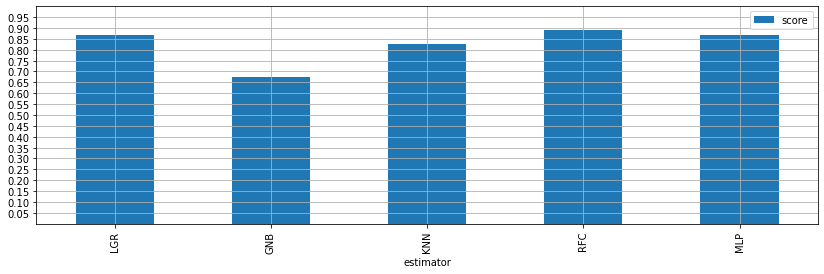

In [44]:
best_estimators.plot.bar(x='estimator', y='score', logy=False, ylim=[0, 1], grid=True, yticks=np.arange(0.05, 1, 0.05), figsize=(14, 4))

In [12]:
best_estimators

,estimator,params,score
0,LGR,{'solver': 'sag'},0.818213
1,GNB,{'var_smoothing': 1e-12},0.584995
2,KNN,"{'leaf_size': 10, 'n_neighbors': 10, 'weights'...",0.82638
3,RFC,"{'criterion': 'gini', 'n_estimators': 200}",0.861809
4,MLP,"{'hidden_layer_sizes': (10,)}",0.823792



## 11. Treinamento e avaliação do algorítimo selecionado  


In [10]:
clf = RandomForestClassifier(criterion='gini', n_estimators=200, max_features='sqrt').fit(X_train, y_train['INSUCESSO'])

#### - Relatório de classificação  

In [12]:
#evaluation
X_test, y_test = load_bases(type='test')
X_test = data_preparation(transformers, X_test)
X_test = pca.transform(X_test)

p = clf.predict(X_test)
print(classification_report(y_test['INSUCESSO'], p))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       489
           1       0.88      0.85      0.86       468

    accuracy                           0.87       957
   macro avg       0.87      0.87      0.87       957
weighted avg       0.87      0.87      0.87       957



#### - Mean Squared Error

In [13]:
print(f'Mean Squared Error: {mean_squared_error(y_test, p)}\n')

Mean Squared Error: 0.17185322805387832



## 12. Armazenhamento do modelo treinado em formato pickle
> A finalidade é que o modelo treinado possa ser utilizado em outra aplicação a partir do carregamento do arquivo pickle.  

In [14]:
def save_model(object_model, filename):
    with open(filename, 'wb') as fd:
        pickle.dump(object_model, fd)

In [15]:

class MLModel(object):
    def __init__(self, transformers, pca, clf):
        self.transformers = transformers
        self.pca = pca
        self.clf = clf
        
save_model(MLModel(transformers, pca, clf), 'model.pickle')

In [16]:
import pandas as pd
import pickle
import numpy as np

def load_model(filename):
    with open(filename, 'rb') as fd:
        object_model = pickle.load(fd)

    return object_model

In [44]:
conv = pd.read_csv('convenios_em_execucao.tsv.gz', compression='gzip', sep='\t', encoding='utf-8', decimal=',')
X_conv = conv.drop(['NR_CONVENIO'], axis=1)
#X_conv.astype({'VL_REPASSE_CONV': 'float64', 'VL_CONTRAPARTIDA_CONV': 'float64', 'VALOR_EMENDA_CONVENIO': 'float64'})
#X_conv = conv.drop(['NR_CONVENIO', 'UF'], axis=1)
#X_conv['OBJETO_PROPOSTA'] = text_transformer.predict(X_conv['OBJETO_PROPOSTA'])
#X_conv['OBJETO_PROPOSTA'] = X_conv['OBJETO_PROPOSTA'].astype('int64')

In [42]:
ml_obj = load_model('model.pickle')
X_conv = ml_obj.data_preparation(ml_obj.transformers, X_conv)
X_conv = ml_obj.pca.transform(X_conv)

In [45]:
conv['INSUCESSO'] = ml_obj.clf.predict(X_conv)
conv['INSUCESSO_PROBA'] = ml_obj.clf.predict_proba(X_conv)[:, 1]

In [52]:
conv[conv['INSUCESSO']==1].sort_values(['INSUCESSO_PROBA'], ascending=False)

,NR_CONVENIO,VL_REPASSE_CONV,VL_CONTRAPARTIDA_CONV,VALOR_EMENDA_CONVENIO,OBJETO_PROPOSTA,COD_ORGAO,COD_ORGAO_SUP,NATUREZA_JURIDICA,MODALIDADE,IDENTIF_PROPONENTE,COM_EMENDAS,CODIGO_IBGE,PRINCIPAL_PARLAMENTAR,PRINCIPAL_FORNECEDOR,INSUCESSO,INSUCESSO_PROBA
53701,704463,100000.0,5040.00,0.0,REALIZAÇÃO DA 29ª EXPOGAL - EXPOSIÇÃO DE GADO ...,54000,54000,Administração Pública Municipal,CONVENIO,18140764000148,0,3156908,NAO APLICAVEL,NAO APLICAVEL,1,1.000000
3418,700614,161500.0,8500.00,0.0,Apoio para a realização da 4ª Festa de Peão de...,54000,54000,Administração Pública Municipal,CONVENIO,1799683000151,0,5214101,NAO APLICAVEL,NAO APLICAVEL,1,1.000000
91445,736645,100000.0,5000.00,0.0,14º FESTA DO PEÃO DE BOIADEIRO DE GUARACIABA / MG,54000,54000,Administração Pública Municipal,CONVENIO,19382647000153,0,3128204,NAO APLICAVEL,NAO APLICAVEL,1,1.000000
78400,704928,100000.0,10000.00,0.0,4ª FESTA DA COLHEITA,54000,54000,Administração Pública Municipal,CONVENIO,18392548000190,0,3116001,NAO APLICAVEL,NAO APLICAVEL,1,1.000000
78341,717585,200000.0,8500.00,0.0,Festividades Natalinas de Miranorte,54000,54000,Administração Pública Municipal,CONVENIO,2070720000159,0,1713304,NAO APLICAVEL,NAO APLICAVEL,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4273,839163,220426.0,661.28,220426.0,Aquisição de Equipamento- Veículo utilitário t...,52000,52000,Administração Pública Municipal,CONVENIO,5943030000155,1,1400100,NAO APLICAVEL,NAO APLICAVEL,1,0.501250
60753,762199,100000.0,2500.00,100000.0,Aquisi��o de Patrulha Rural Mecanizada.,53207,53000,Administração Pública Municipal,CONVENIO,18192260000171,1,3137106,NAO APLICAVEL,NAO APLICAVEL,1,0.500833
154979,923769,960019.0,1981.00,0.0,Pavimentação em bloco intertravado no Municípi...,53000,53000,Administração Pública Municipal,CONTRATO DE REPASSE,7000300000110,0,2105500,NAO APLICAVEL,NAO APLICAVEL,1,0.500778
18333,857539,496663.0,0.00,0.0,Implantação de Melhorias Sanitárias Domiciliar...,36211,36000,Administração Pública Municipal,CONVENIO,87612909000189,0,4313805,NAO APLICAVEL,NAO APLICAVEL,1,0.500625


In [48]:
df = pd.read_csv('./datasets/convenios.txt.gz', compression='gzip', sep='\t', encoding='utf-8')

In [50]:
df.shape

(31822, 14)